In [ ]:
import pandas as pd
test=pd.read_csv('/content/merged_output.csv',low_memory=False)
rawdataset=pd.read_csv('/content/dataset.csv',low_memory=False)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646584 entries, 0 to 646583
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   공고번호        646584 non-null  object 
 1   차수          646584 non-null  int64  
 2   공고명_x       646584 non-null  object 
 3   기초금액        646584 non-null  int64  
 4   예가범위        646584 non-null  float64
 5   난이도계수       16932 non-null   float64
 6   안전관리비비율     646584 non-null  float64
 7   품질관리비비율     646584 non-null  float64
 8   공고명_y       626701 non-null  object 
 9   추정가격        626700 non-null  float64
 10  낙찰하한율       626434 non-null  float64
 11  예산대비추정가     626699 non-null  float64
 12  관급비비중       626699 non-null  float64
 13  순공사비        582190 non-null  float64
 14  VAT비율       582189 non-null  float64
 15  입찰준비기간      626701 non-null  float64
 16  공고개찰기간      626701 non-null  float64
 17  자격등록기간      626701 non-null  float64
 18  참가제한        626701 non-null  object 
 19  업종

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595753 entries, 0 to 595752
Data columns (total 47 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   기초금액        595753 non-null  int64  
 1   예가범위        595753 non-null  float64
 2   난이도계수       595753 non-null  float64
 3   안전관리비비율     595753 non-null  float64
 4   품질관리비비율     595753 non-null  float64
 5   추정가격        595753 non-null  float64
 6   낙찰하한율       595753 non-null  float64
 7   예산대비추정가     595753 non-null  float64
 8   관급비비중       595753 non-null  float64
 9   순공사비        595753 non-null  float64
 10  VAT비율       595753 non-null  float64
 11  입찰준비기간      595753 non-null  float64
 12  공고개찰기간      595753 non-null  float64
 13  자격등록기간      595753 non-null  float64
 14  참가제한        595753 non-null  int64  
 15  지역의무공동계약여부  595753 non-null  int64  
 16  재공고여부       595753 non-null  int64  
 17  낙찰가         595753 non-null  float64
 18  난이도계수_적용여부  595753 non-null  int64  
 19  안전

In [ ]:
# ==========================================
# 라이브러리
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import shap

In [ ]:
# ==========================================
# 1. Train / Test Split
# ==========================================
target_col='낙찰가'
dataset= rawdataset.sample(n=100_000, random_state=42)
X = dataset.drop(columns=[target_col])
y = dataset[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train :{}, X_test : {}, y_train :{}, y_test : {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train :(80000, 46), X_test : (20000, 46), y_train :(80000,), y_test : (20000,)


In [ ]:
# ==========================================
# 2. Scaling (입력 + 출력)
# ==========================================
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

In [ ]:
# ==========================================
# 3. RandomForest 학습
# ==========================================
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=20,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=20,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
# ==========================================
# 4. Permutation Importance
# ==========================================
perm = permutation_importance(
    model,
    X_test_scaled,
    y_test_scaled,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": X.columns,
    "perm_importance": perm.importances_mean
})

In [ ]:
# ==========================================
# 5. SHAP 계산 (샘플링 적용)
# ==========================================
shap_sample_size = 5000

shap_idx = np.random.choice(
    X_train_scaled.shape[0],
    size=shap_sample_size,
    replace=False
)

X_shap = X_train_scaled[shap_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_shap)

shap_importance = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": X.columns,
    "shap_importance": shap_importance
})

In [ ]:
# ==========================================
# 6. Importance 통합
# ==========================================
importance_df = perm_df.merge(shap_df, on="feature")

# 정규화 (비교 용이)
importance_df["perm_norm"] = (
    importance_df["perm_importance"] / importance_df["perm_importance"].sum()
)
importance_df["shap_norm"] = (
    importance_df["shap_importance"] / importance_df["shap_importance"].sum()
)

importance_df["mean_importance"] = (
    importance_df["perm_norm"] + importance_df["shap_norm"]
) / 2

importance_df = importance_df.sort_values(
    by="mean_importance", ascending=False
)

print("\n=== Combined Feature Importance ===")
print(importance_df.head(20))


=== Combined Feature Importance ===
       feature  perm_importance  shap_importance  perm_norm  shap_norm  \
0         기초금액         0.199734         0.113235   0.361177   0.239799   
5         추정가격         0.145724         0.094569   0.263512   0.200271   
9         순공사비         0.075770         0.069068   0.137014   0.146266   
6        낙찰하한율         0.033578         0.047619   0.060718   0.100843   
2        난이도계수         0.029185         0.015178   0.052776   0.032144   
17  난이도계수_적용여부         0.017598         0.010915   0.031822   0.023116   
4      품질관리비비율         0.007998         0.016349   0.014462   0.034623   
19  품질관리비_적용여부         0.009421         0.014365   0.017035   0.030422   
15  지역의무공동계약여부         0.011162         0.010368   0.020184   0.021956   
21    관급비_적용여부         0.003182         0.010941   0.005753   0.023170   
8        관급비비중         0.001796         0.012094   0.003247   0.025613   
10       VAT비율         0.003264         0.010226   0.005902   0.021655   
3

In [ ]:
# ==========================================
# 한글 폰트 설정 (Windows)
# ==========================================
!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 경로
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 등록
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 기본 폰트로 설정
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


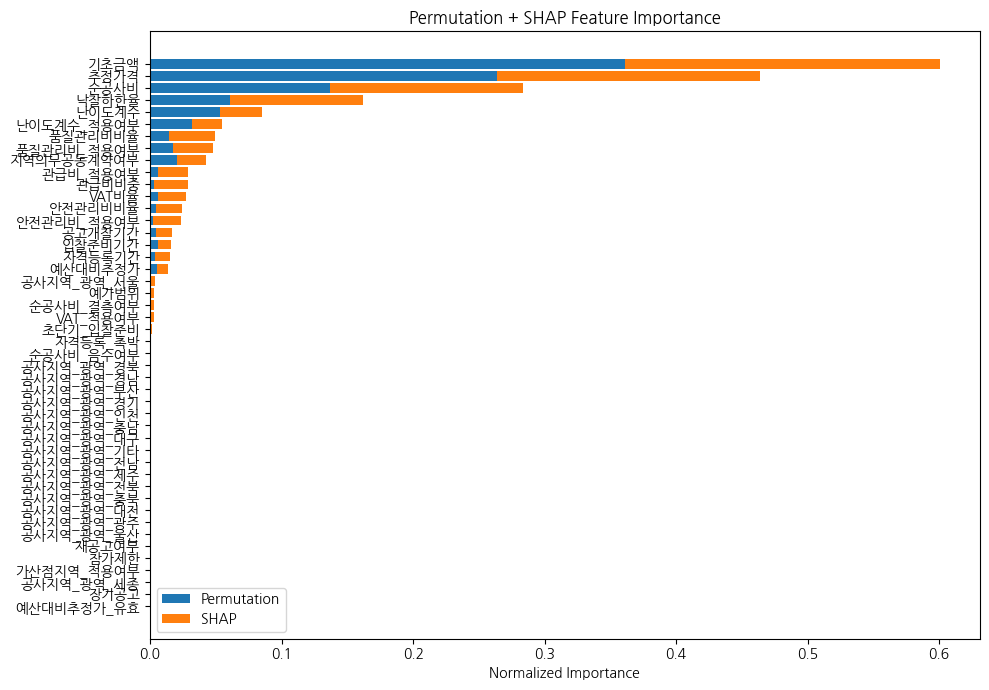

In [ ]:
# ==========================================
# 7. 하나의 그래프에서 비교
# ==========================================
top_k = 50
plot_df = importance_df.head(top_k)

plt.figure(figsize=(10, 7))
plt.barh(plot_df["feature"], plot_df["perm_norm"], label="Permutation")
plt.barh(plot_df["feature"], plot_df["shap_norm"], left=plot_df["perm_norm"], label="SHAP")

plt.xlabel("Normalized Importance")
plt.title("Permutation + SHAP Feature Importance")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
importance_df.loc[importance_df["feature"]=="재공고여부"]

,feature,perm_importance,shap_importance,perm_norm,shap_norm,mean_importance
16,재공고여부,-1.401360e-07,0.000009,-2.534068e-07,0.00002,0.00001


In [ ]:
#->공사지역을 수도권/비수도권으로, VAT적용여부까지만 활용. 나머지는 작아서 미미하니 drop처리

In [ ]:
# VAT 적용여부 이후 feature 자동 제거
cut_feature = "VAT_적용여부"

drop_features = importance_df[
    importance_df["feature"].tolist().index(cut_feature) + 1 :
]["feature"].tolist()

X_train_reduced = X_train.drop(columns=drop_features)
X_test_reduced  = X_test.drop(columns=drop_features)

print("제거된 feature 수:", len(drop_features))

제거된 feature 수: 24


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 기존 모델
pred_full = model.predict(X_test_scaled)
rmse_full = np.sqrt(mean_squared_error(y_test, pred_full))

# feature 제거 후 재학습
model_reduced = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model_reduced.fit(X_train_reduced, y_train)

pred_reduced = model_reduced.predict(X_test_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_test, pred_reduced))

print(f"RMSE (full):     {rmse_full:.2f}")
print(f"RMSE (reduced):  {rmse_reduced:.2f}")

RMSE (full):     830256704.77
RMSE (reduced):  13922643.35


In [ ]:
830256704.77>13922643.35

True

In [ ]:
model_origin=RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model_origin.fit(X_train_reduced[['기초금액','예가범위','낙찰하한율','추정가격']], y_train)

pred_origin = model_origin.predict(X_test_reduced[['기초금액','예가범위','낙찰하한율','추정가격']])
rmse_origin = np.sqrt(mean_squared_error(y_test, pred_origin))


In [ ]:
print(f"RMSE (reduced):  {rmse_origin:.2f}")
print(rmse_reduced>rmse_origin)

RMSE (reduced):  12919210.54
True


In [ ]:
cut_feature = "VAT_적용여부"

features_sorted = importance_df["feature"].tolist()
cut_idx = features_sorted.index(cut_feature)

drop_features = features_sorted[cut_idx + 1:]

print(drop_features)

['초단기_입찰준비', '자격등록_촉박', '순공사비_음수여부', '공사지역_광역_경북', '공사지역_광역_경남', '공사지역_광역_부산', '공사지역_광역_경기', '공사지역_광역_인천', '공사지역_광역_충남', '공사지역_광역_대구', '공사지역_광역_기타', '공사지역_광역_전남', '공사지역_광역_제주', '공사지역_광역_전북', '공사지역_광역_충북', '공사지역_광역_대전', '공사지역_광역_광주', '공사지역_광역_울산', '재공고여부', '참가제한', '가산점지역_적용여부', '공사지역_광역_세종', '장기공고', '예산대비추정가_유효']


In [ ]:
dataset_reduced = rawdataset.drop(columns=drop_features)

print("Before:", rawdataset.shape)
print("After :", dataset_reduced.shape)

Before: (595753, 47)
After : (595753, 23)


In [ ]:
dataset_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595753 entries, 0 to 595752
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   기초금액        595753 non-null  int64  
 1   예가범위        595753 non-null  float64
 2   난이도계수       595753 non-null  float64
 3   안전관리비비율     595753 non-null  float64
 4   품질관리비비율     595753 non-null  float64
 5   추정가격        595753 non-null  float64
 6   낙찰하한율       595753 non-null  float64
 7   예산대비추정가     595753 non-null  float64
 8   관급비비중       595753 non-null  float64
 9   순공사비        595753 non-null  float64
 10  VAT비율       595753 non-null  float64
 11  입찰준비기간      595753 non-null  float64
 12  공고개찰기간      595753 non-null  float64
 13  자격등록기간      595753 non-null  float64
 14  지역의무공동계약여부  595753 non-null  int64  
 15  낙찰가         595753 non-null  float64
 16  난이도계수_적용여부  595753 non-null  int64  
 17  안전관리비_적용여부  595753 non-null  int64  
 18  품질관리비_적용여부  595753 non-null  int64  
 19  관급

In [ ]:
dataset_reduced.to_csv("dataset_feature_selected.csv",index=False,encoding="utf-8-sig")